### Download the tutorial with temporal network outputs for SGD variants and SGLD optimization [here](https://www.dropbox.com/s/b4hutpvrpw2edp2/Image_Denoising.ipynb?dl=0)

### Import libs

In [1]:
from __future__ import print_function
import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
from models import *
import torch
import torch.optim
import time
from skimage.measure import compare_psnr
from utils.denoising_utils import *
import _pickle as cPickle
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor
import seaborn as sns
from tqdm import tqdm
import tifffile
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# display images
def np_plot(np_matrix, title):
    plt.clf()
    fig = plt.imshow(np_matrix.transpose(1, 2, 0), interpolation = 'nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title(title)
    plt.axis('off')
    plt.pause(0.05) 

### Load images

clean: 0.01 -- 0.94
noisy: -4.99 -- 5.06
data_range: 0.93


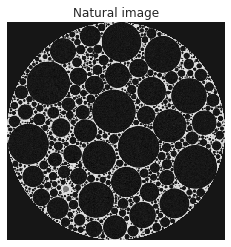

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


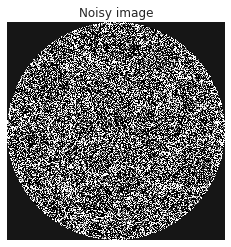

In [2]:
# We load the original bell pepper image as well. 
# img_pil.size is used later in the code. 
# Fortunately, the foam images and the bell pepper both all have size 512 x 512

fname = 'data/denoising/Dataset/image_Peppers512rgb.png'
imsize =-1
img_pil = crop_image(get_image(fname, imsize)[0], d=32)


fname_clean = '/ufs/hendriks/bigstore/hendriks/noise2noise/foam_comparison/absorption_10_I0_100_msd/object0/reconstructions/clean/output_00256.tif'
fname_noisy = '/ufs/hendriks/bigstore/hendriks/noise2noise/foam_comparison/absorption_10_I0_100_msd/object0/reconstructions/num_splits_1/0/output_00256.tif'

# Load foam images
clean_foam = tifffile.imread(fname_clean)[None, ...]
noisy_foam = tifffile.imread(fname_noisy)[None, ...]

# make 3 channels 
clean_foam_color = np.concatenate((clean_foam,) * 3, )
noisy_foam_color = np.concatenate((noisy_foam,) * 3, )

# Make sure clean image intensity range is roughly 0 -- 1
img_np = clean_foam_color * 200 + 0.09
img_noisy_np = noisy_foam_color * 200 + 0.09

print(f"clean: {img_np.min():0.2f} -- {img_np.max():0.2f}")
print(f"noisy: {img_noisy_np.min():0.2f} -- {img_noisy_np.max():0.2f}")
data_range = img_np.max() - img_np.min()
# Data range is for calculating the psnr in the code below. 
# This is necessary, because some image values will fall outside the range [0,1]
print(f"data_range: {data_range:0.2f}")


# Plot
np_plot(img_np, 'Natural image')
np_plot(img_noisy_np, 'Noisy image')

### Hyper-parameters

In [3]:
INPUT = 'noise'
pad = 'reflection'
OPT_OVER = 'net' # optimize over the net parameters only
reg_noise_std = 1./30.
learning_rate = LR = 0.01
exp_weight=0.99
input_depth = 32 
roll_back = True # to prevent numerical issues
num_iter = 20000 # max iterations
burnin_iter = 7000 # burn-in iteration for SGLD
weight_decay = 5e-8
show_every =  500
mse = torch.nn.MSELoss().type(dtype) # loss
img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

### SGD variant 

#### (1) SGD  and (2) SGD + moving average

In [ ]:
check_point = 500 # checkout the prediction at 500-th iteration

# skip net
net = get_net(input_depth, 'skip', pad,
            skip_n33d=128, 
            skip_n33u=128,
            skip_n11=4,
            num_scales=5,
            upsample_mode='bilinear').type(dtype)

# Optimize
net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()
out_avg = None
last_net = None
psrn_noisy_last = 0
i = 0

# save tmp PSNR for different learning strategies
sgd_noise_psnr_list = [] # psnr between out and noise image
sgd_psnr_list = [] # psnr between sgd out and gt
sgd_expm_psnr_list = [] # psnr between exp avg and gt
sgd_mse_list = [] # Mean squared error

sgd_out_500 = None
sgd_expm_out_500 = None

def closure():

    global i, out_avg, psrn_noisy_last, last_net, net_input, sgd_out_500, sgd_expm_out_500
    out = net(net_input)
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()

    out_np = out.detach().cpu().numpy()[0]
    out_avg_np = out_avg.detach().cpu().numpy()[0]

    psrn_noisy = compare_psnr(img_noisy_np, out_np)
    psrn_gt    = compare_psnr(img_np, out_np)
    psrn_gt_sm = compare_psnr(img_np, out_avg_np)

    sgd_noise_psnr_list.append(psrn_noisy)
    sgd_psnr_list.append(psrn_gt)
    sgd_expm_psnr_list.append(psrn_gt_sm)

    if i % show_every == 0:
        np_plot(out.detach().cpu().numpy()[0], 'Iter: %d; gt %.2f; sm %.2f' % (i, psrn_gt, psrn_gt_sm))
        
    if i == check_point - 1:
        sgd_out_500 =  out_np
        sgd_expm_out_500 =  out_avg_np

    # Backtracking (TODO: check this later)
    if roll_back and i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')
            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.detach().copy_(new_param.cuda())
            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy

    i += 1
    return total_loss

## Optimizing 
print('Starting optimization with ADAM')
optimizer = torch.optim.Adam(net.parameters(), lr=LR)
for j in range(num_iter):
    optimizer.zero_grad()
    closure()
    optimizer.step()

torch.cuda.empty_cache()

#### (3) SGD + weight decay

In [ ]:
check_point = 500 # checkout the prediction at 500-th iteration

# skip net
net = get_net(input_depth, 'skip', pad,
            skip_n33d=128, 
            skip_n33u=128,
            skip_n11=4,
            num_scales=5,
            upsample_mode='bilinear').type(dtype)

# Optimize
net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()
out_avg = None
last_net = None
psrn_noisy_last = 0
i = 0

sgd_wd_psnr_list = [] # psnr between sgd out and gt

def closure():

    global i, out_avg, psrn_noisy_last, last_net, net_input
    out = net(net_input)
    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()

    out_np = out.detach().cpu().numpy()[0]
    psrn_noisy = compare_psnr(img_noisy_np, out_np)
    psrn_gt    = compare_psnr(img_np, out_np)
    sgd_wd_psnr_list.append(psrn_gt)

    if i % show_every == 0:
        np_plot(out.detach().cpu().numpy()[0], 'Iter: %d; gt %.2f' % (i, psrn_gt))
        
    # Backtracking
    if roll_back and i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')
            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.detach().copy_(new_param.cuda())
            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy

    i += 1
    return total_loss

## Optimizing 
print('Starting optimization with ADAM')
optimizer = torch.optim.Adam(net.parameters(), lr=LR, weight_decay = weight_decay) ## SGD + weight decay
for j in range(num_iter):
    optimizer.zero_grad()
    closure()
    optimizer.step()

torch.cuda.empty_cache()

#### (4) SGD + input noise  and (5) SGD + input noise + moiving average

In [ ]:
def auto_encoder_kernel_sigma():
    input_sigma_list = [0, 20, 60, 120]
    num_layers = 3
    color = ['r', 'b', 'g', 'y']
    for idx, in_sigma in enumerate(input_sigma_list):
        samples = prior_sampling(in_sigma, net_width, num_layers, num_samples = 50000, out_size = 2048, cnn = 'auto_encoder')
        mean, kd = compute_mean_cov_from_samples(samples, margin = 1000)        
        NN_cos_ang = kd/kd[0]
        x = np.arange(-len(mean)+1, len(mean))
        nn_cos_all = np.concatenate((np.flip(NN_cos_ang), NN_cos_ang[1:]))
        plt.plot(x, nn_cos_all, color[idx], label = r'$\sigma=%d$'% in_sigma)
        plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.00001), ncol=4, prop={'size':9})
    plt.xlabel(r'$t_1 - t_2$' + r'  ($d=3$)')
    plt.ylabel(r'$\cos \theta_{t_1, t_2}$')
    plt.show()check_point = 1800

net = get_net(input_depth, 'skip', pad,
            skip_n33d=128, 
            skip_n33u=128,
            skip_n11=4,
            num_scales=5,
            upsample_mode='bilinear').type(dtype)

## Optimize
net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0
show_every = 100
i = 0

# save tmp PSNR for different learning strategies
fancy_sgd_noise_psnr_list = [] # psnr between out and noise image
fancy_sgd_psnr_list = [] # psnr between sgd out and gt
fancy_sgd_expm_psnr_list = [] # psnr between exp avg and gt
fancy_sgd_out_1800 = None
fancy_sgd_expm_out_1800 = None

def closure():

    global i, out_avg, psrn_noisy_last, last_net, net_input, fancy_sgd_out_1800, fancy_sgd_expm_out_1800
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    out = net(net_input)
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()

    out_np = out.detach().cpu().numpy()[0]
    out_avg_np = out_avg.detach().cpu().numpy()[0]

    psrn_noisy = compare_psnr(img_noisy_np, out_np)
    psrn_gt    = compare_psnr(img_np, out_np)
    psrn_gt_sm = compare_psnr(img_np, out_avg_np)

    fancy_sgd_noise_psnr_list.append(psrn_noisy)
    fancy_sgd_psnr_list.append(psrn_gt)
    fancy_sgd_expm_psnr_list.append(psrn_gt_sm)

    if i == check_point - 1:
        fancy_sgd_out_1800 =  out_np
        fancy_sgd_expm_out_1800 =  out_avg_np

    if i % show_every == 0:
        np_plot(out.detach().cpu().numpy()[0], 'Iter: %d; gt %.2f; sm %.2f' % (i, psrn_gt, psrn_gt_sm))

    # Backtracking
    if roll_back and i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')
            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.detach().copy_(new_param.cuda())
            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy

    i += 1
    return total_loss

## Optimizing 
print('Starting optimization with ADAM')
optimizer = torch.optim.Adam(net.parameters(), lr=LR)
for j in range(num_iter):
    optimizer.zero_grad()
    closure()
    optimizer.step()

torch.cuda.empty_cache()

### SGLD 

  0%|          | 0/20000 [00:00<?, ?it/s]

Starting optimization with SGLD


/export/scratch1/hendriks/miniconda3/envs/noise2noise/lib/python3.6/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


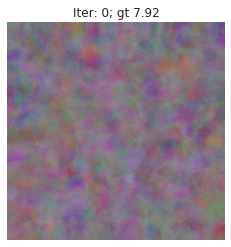

  2%|▎         | 500/20000 [01:52<1:10:57,  4.58it/s]

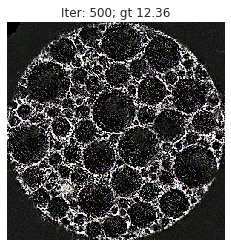

  5%|▌         | 1000/20000 [03:41<1:08:44,  4.61it/s]

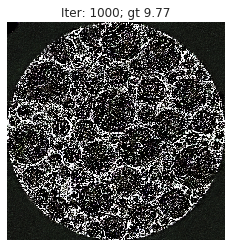

  8%|▊         | 1500/20000 [05:29<1:07:04,  4.60it/s]

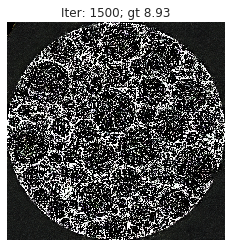

 10%|█         | 2000/20000 [07:18<1:05:06,  4.61it/s]

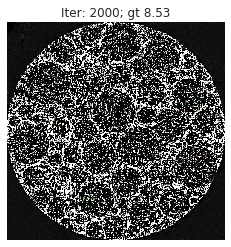

 12%|█▎        | 2500/20000 [09:07<1:03:43,  4.58it/s]

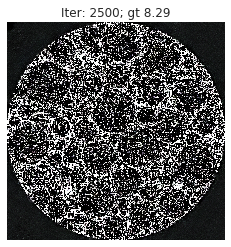

 15%|█▌        | 3000/20000 [10:56<1:01:27,  4.61it/s]

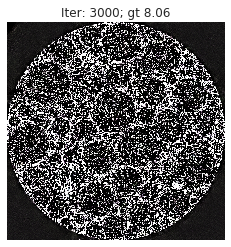

 18%|█▊        | 3500/20000 [12:45<59:50,  4.60it/s]  

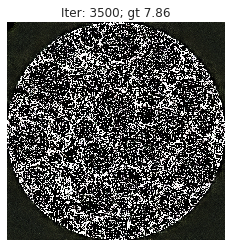

 20%|██        | 4000/20000 [14:34<58:03,  4.59it/s]  

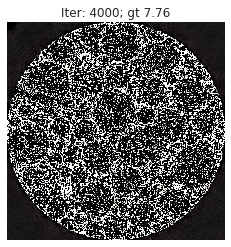

 22%|██▎       | 4500/20000 [16:23<57:00,  4.53it/s]  

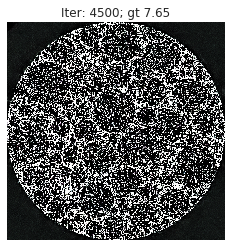

 25%|██▌       | 5000/20000 [18:13<54:47,  4.56it/s]  

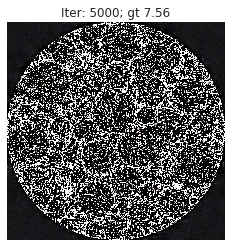

 28%|██▊       | 5500/20000 [20:02<52:36,  4.59it/s]  

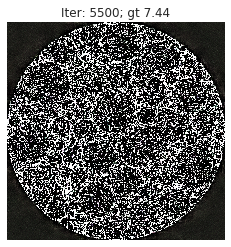

 30%|███       | 6000/20000 [21:51<51:03,  4.57it/s]  

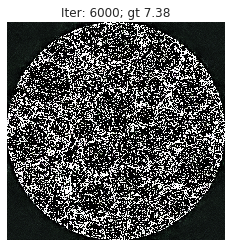

 32%|███▎      | 6500/20000 [23:41<49:09,  4.58it/s]  

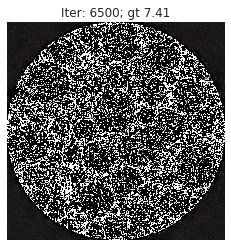

 35%|███▌      | 7000/20000 [25:30<47:09,  4.59it/s]

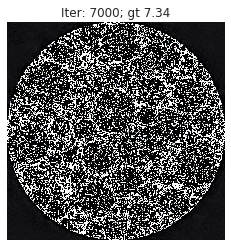

 38%|███▊      | 7500/20000 [27:21<46:00,  4.53it/s]

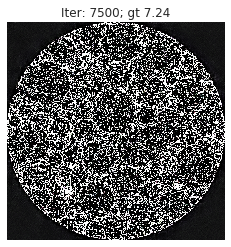

 40%|████      | 8000/20000 [29:11<44:07,  4.53it/s]

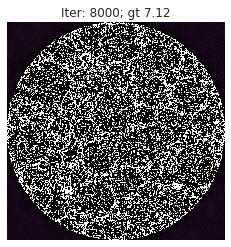

 42%|████▎     | 8500/20000 [31:02<42:14,  4.54it/s]

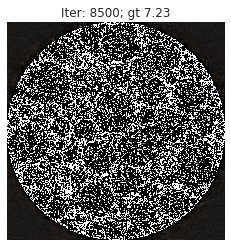

 45%|████▌     | 9000/20000 [32:52<40:17,  4.55it/s]

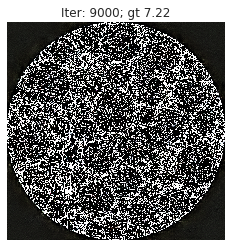

 48%|████▊     | 9500/20000 [34:42<38:31,  4.54it/s]

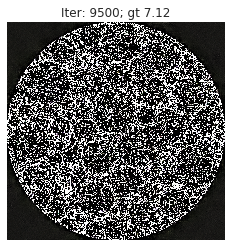

 50%|█████     | 10000/20000 [36:33<36:43,  4.54it/s]

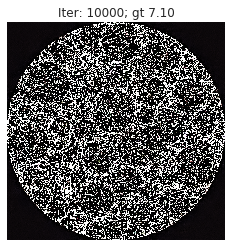

 52%|█████▎    | 10500/20000 [38:23<34:57,  4.53it/s]

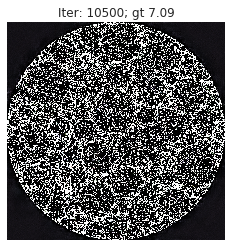

 55%|█████▌    | 11000/20000 [40:13<32:56,  4.55it/s]

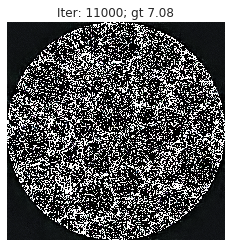

 57%|█████▊    | 11500/20000 [42:04<31:14,  4.54it/s]

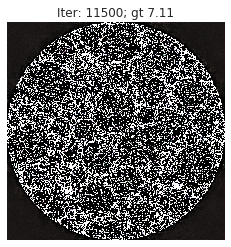

 60%|██████    | 12000/20000 [43:54<29:18,  4.55it/s]

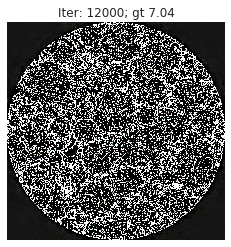

 62%|██████▎   | 12500/20000 [45:45<27:31,  4.54it/s]

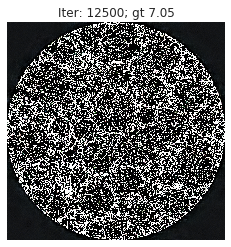

 65%|██████▌   | 13000/20000 [47:35<25:46,  4.53it/s]

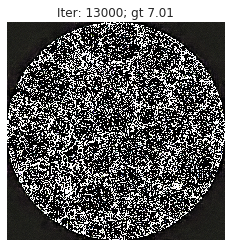

 68%|██████▊   | 13500/20000 [49:26<23:50,  4.54it/s]

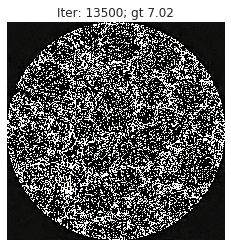

 70%|███████   | 14000/20000 [51:16<22:03,  4.53it/s]

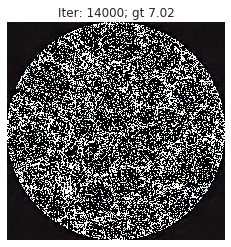

 72%|███████▎  | 14500/20000 [53:07<20:06,  4.56it/s]

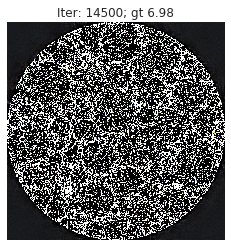

 75%|███████▌  | 15000/20000 [54:57<18:21,  4.54it/s]

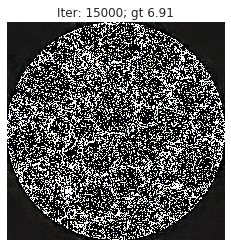

 78%|███████▊  | 15500/20000 [56:48<16:28,  4.55it/s]

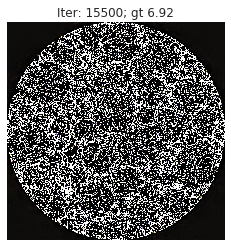

 80%|████████  | 16000/20000 [58:38<14:41,  4.54it/s]

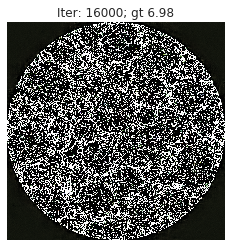

 82%|████████▎ | 16500/20000 [1:00:29<12:53,  4.52it/s]

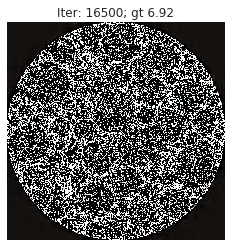

 85%|████████▌ | 17000/20000 [1:02:19<11:01,  4.54it/s]

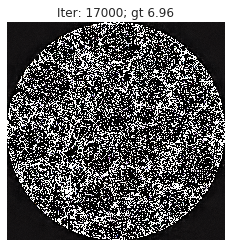

 88%|████████▊ | 17500/20000 [1:04:09<09:11,  4.53it/s]

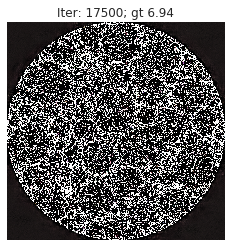

 90%|█████████ | 18000/20000 [1:06:00<07:22,  4.52it/s]

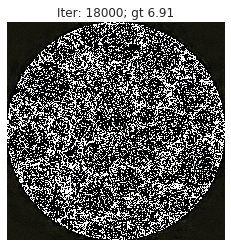

 92%|█████████▎| 18500/20000 [1:07:50<05:31,  4.53it/s]

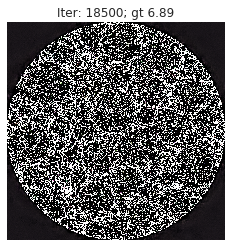

 95%|█████████▌| 19000/20000 [1:09:41<03:39,  4.55it/s]

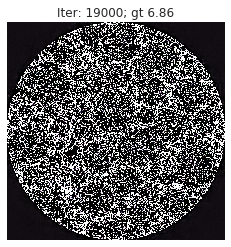

 98%|█████████▊| 19500/20000 [1:11:31<01:50,  4.53it/s]

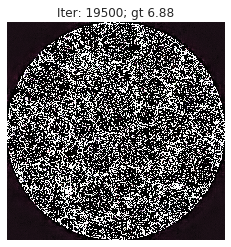

100%|██████████| 20000/20000 [1:13:21<00:00,  4.54it/s]


In [4]:
sgld_psnr_list = [] # psnr between sgld out and gt
sgld_mean = 0
roll_back = True # To solve the oscillation of model training 
last_net = None
psrn_noisy_last = 0
MCMC_iter = 50
param_noise_sigma = 2

sgld_mean_each = 0
sgld_psnr_mean_list = [] # record the PSNR of avg after burn-in

def cache_sample(iteration, data):
    with open(dirname_samples + '/%d'%iteration, 'wb') as f:
        cPickle.dump(data, f)

## SGLD
def add_noise(model):
    for n in [x for x in model.parameters() if len(x.size()) == 4]:
        noise = torch.randn(n.size())*param_noise_sigma*learning_rate
        noise = noise.type(dtype)
        n.data = n.data + noise

net2 = get_net(input_depth, 'skip', pad,
            skip_n33d=128, 
            skip_n33u=128,
            skip_n11=4,
            num_scales=5,
            upsample_mode='bilinear').type(dtype)

## Input random noise
net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
i = 0

sample_count = 0

def closure_sgld():
    global i, net_input, sgld_mean, sample_count, psrn_noisy_last, last_net, sgld_mean_each
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    out = net2(net_input)
    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()
    out_np = out.detach().cpu().numpy()[0]

    psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0], data_range=data_range)
    psrn_gt    = compare_psnr(img_np, out_np, data_range=data_range)

    sgld_psnr_list.append(psrn_gt)

    # Backtracking
    if roll_back and i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')
            for new_param, net_param in zip(last_net, net2.parameters()):
                net_param.detach().copy_(new_param.cuda())
            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net2.parameters()]
            psrn_noisy_last = psrn_noisy

    if i % show_every == 0:
        np_plot(out.detach().cpu().numpy()[0], 'Iter: %d; gt %.2f' % (i, psrn_gt))
    
    if i > burnin_iter and np.mod(i, MCMC_iter) == 0:
        sgld_mean += out_np
        sample_count += 1.

    if i > burnin_iter:
        sgld_mean_each += out_np
        sgld_mean_tmp = sgld_mean_each / (i - burnin_iter)
        sgld_mean_psnr_each = compare_psnr(img_np, sgld_mean_tmp, data_range=data_range)
        sgld_psnr_mean_list.append(sgld_mean_psnr_each) # record the PSNR of avg after burn-in

    i += 1
    return total_loss


  ## Optimizing 
print('Starting optimization with SGLD')
optimizer = torch.optim.Adam(net2.parameters(), lr=LR, weight_decay = weight_decay)
for j in tqdm(range(num_iter)):
    optimizer.zero_grad()
    closure_sgld()
    optimizer.step()
    add_noise(net2)

sgld_mean = sgld_mean / sample_count
sgld_mean_psnr = compare_psnr(img_np, sgld_mean)

### Compare SGD variants and SGLD

#### PSNR curve 

Text(0, 0.5, 'PSNR (dB)')

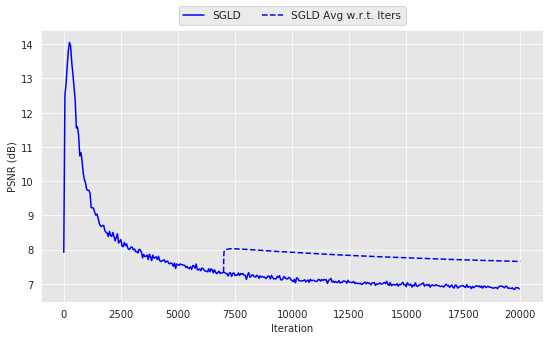

In [5]:
plt.figure(1, figsize=(9,5))    
num_iter = len(sgld_psnr_list)


sgld_psnr_mean_list = np.array(sgld_psnr_mean_list)
sgld_psnr_list = np.array(sgld_psnr_list)


# SGD
x_iters = np.arange(0, num_iter, 50)


# SGLD
x_iters_after_burnin = np.arange(len(sgld_psnr_mean_list)) + burnin_iter 
plt.plot(x_iters, sgld_psnr_list[x_iters], 'b', label = 'SGLD')
plt.plot(np.arange(burnin_iter, num_iter-1), sgld_psnr_mean_list, 'b--', label = 'SGLD Avg w.r.t. Iters')
# plt.plot([0, 5000, 10000, 15000, 20000], [sgld_mean_psnr] * 5, '--bo', label = 'SGLD Avg')

plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.0001), ncol = 4, prop={'size':10.5})
plt.xlabel('Iteration')
# plt.xticks([0, 5000, 10000, 15000, 20000], ('0', '5K', '10K', '15K', '20K'))
# plt.ylim(20, 31)
plt.ylabel('PSNR (dB)')